# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
#!pip -q install ./python

In [2]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from utils import *
from agentDDPG import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


# DDGP

In [6]:
agents = [Agent(state_size, action_size, num_agents = 1, random_seed=10) for i in range(num_agents)]

In [7]:
def ddpg():
    scores_deque = deque(maxlen=100)
    agent_scores = []
    scores_window = []
    scores_moving_avg = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = np.reshape(env_info.vector_observations, (1,num_agents*state_size)) # flatten states  
        
        for agent in agents:
            agent.reset()
            
        scores = np.zeros(num_agents) 
        
        for t in range(max_t):
            actions = np.reshape([agent.act(states, add_noise=True) for agent in agents], (1, num_agents*action_size))
            env_info = env.step(actions)[brain_name]
            
            next_states = np.reshape(env_info.vector_observations, (1, num_agents*state_size)) 
            rewards = env_info.rewards                   
            dones = env_info.local_done 
 
            for i, agent in enumerate(agents):
                    agent.step(states, actions, rewards[i], next_states, dones, i,t)  
                    
            states = next_states
            scores += np.max(rewards)
            if np.any(dones):
                break 
        
        
        score = np.max(scores)
        
        scores_deque.append(score)
        scores_window.append(score)
        scores_moving_avg.append(np.mean(scores_window))
        
        
        
                
        print('\rEpisode {}\tAverage Score: {:.4f}\tMax Score: {:.4f}'.format(i_episode, np.mean(scores_deque), np.max(scores_deque), end=""))
            
        if (np.mean(scores_deque) >= TARGET_SCORE):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_tennis.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_tennis.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
            
    return scores_window, scores_moving_avg

In [8]:
scores, scores_mean = ddpg()

Episode 1	Average Score: 0.0000	Max Score: 0.0000
Episode 2	Average Score: 0.0000	Max Score: 0.0000
Episode 3	Average Score: 0.0000	Max Score: 0.0000
Episode 4	Average Score: 0.0000	Max Score: 0.0000
Episode 5	Average Score: 0.0400	Max Score: 0.2000
Episode 6	Average Score: 0.0333	Max Score: 0.2000
Episode 7	Average Score: 0.0286	Max Score: 0.2000
Episode 8	Average Score: 0.0250	Max Score: 0.2000
Episode 9	Average Score: 0.0222	Max Score: 0.2000
Episode 10	Average Score: 0.0200	Max Score: 0.2000
Episode 11	Average Score: 0.0182	Max Score: 0.2000
Episode 12	Average Score: 0.0167	Max Score: 0.2000
Episode 13	Average Score: 0.0154	Max Score: 0.2000
Episode 14	Average Score: 0.0143	Max Score: 0.2000
Episode 15	Average Score: 0.0133	Max Score: 0.2000
Episode 16	Average Score: 0.0125	Max Score: 0.2000
Episode 17	Average Score: 0.0118	Max Score: 0.2000
Episode 18	Average Score: 0.0167	Max Score: 0.2000
Episode 19	Average Score: 0.0158	Max Score: 0.2000
Episode 20	Average Score: 0.0150	Max Sco

Episode 161	Average Score: 0.0750	Max Score: 1.3000
Episode 162	Average Score: 0.0760	Max Score: 1.3000
Episode 163	Average Score: 0.0770	Max Score: 1.3000
Episode 164	Average Score: 0.0770	Max Score: 1.3000
Episode 165	Average Score: 0.0770	Max Score: 1.3000
Episode 166	Average Score: 0.0770	Max Score: 1.3000
Episode 167	Average Score: 0.0780	Max Score: 1.3000
Episode 168	Average Score: 0.0780	Max Score: 1.3000
Episode 169	Average Score: 0.0780	Max Score: 1.3000
Episode 170	Average Score: 0.0780	Max Score: 1.3000
Episode 171	Average Score: 0.0790	Max Score: 1.3000
Episode 172	Average Score: 0.0790	Max Score: 1.3000
Episode 173	Average Score: 0.0790	Max Score: 1.3000
Episode 174	Average Score: 0.0790	Max Score: 1.3000
Episode 175	Average Score: 0.0780	Max Score: 1.3000
Episode 176	Average Score: 0.0770	Max Score: 1.3000
Episode 177	Average Score: 0.0780	Max Score: 1.3000
Episode 178	Average Score: 0.0720	Max Score: 1.3000
Episode 179	Average Score: 0.0720	Max Score: 1.3000
Episode 180	

Episode 319	Average Score: 0.1840	Max Score: 1.4000
Episode 320	Average Score: 0.1850	Max Score: 1.4000
Episode 321	Average Score: 0.1850	Max Score: 1.4000
Episode 322	Average Score: 0.1840	Max Score: 1.4000
Episode 323	Average Score: 0.1850	Max Score: 1.4000
Episode 324	Average Score: 0.1870	Max Score: 1.4000
Episode 325	Average Score: 0.1870	Max Score: 1.4000
Episode 326	Average Score: 0.1870	Max Score: 1.4000
Episode 327	Average Score: 0.1880	Max Score: 1.4000
Episode 328	Average Score: 0.1880	Max Score: 1.4000
Episode 329	Average Score: 0.1880	Max Score: 1.4000
Episode 330	Average Score: 0.1880	Max Score: 1.4000
Episode 331	Average Score: 0.1890	Max Score: 1.4000
Episode 332	Average Score: 0.1900	Max Score: 1.4000
Episode 333	Average Score: 0.1910	Max Score: 1.4000
Episode 334	Average Score: 0.1920	Max Score: 1.4000
Episode 335	Average Score: 0.1870	Max Score: 1.4000
Episode 336	Average Score: 0.1860	Max Score: 1.4000
Episode 337	Average Score: 0.1850	Max Score: 1.4000
Episode 338	

Episode 477	Average Score: 0.1670	Max Score: 0.8000
Episode 478	Average Score: 0.1680	Max Score: 0.8000
Episode 479	Average Score: 0.1660	Max Score: 0.8000
Episode 480	Average Score: 0.1650	Max Score: 0.8000
Episode 481	Average Score: 0.1620	Max Score: 0.8000
Episode 482	Average Score: 0.1600	Max Score: 0.8000
Episode 483	Average Score: 0.1560	Max Score: 0.8000
Episode 484	Average Score: 0.1560	Max Score: 0.8000
Episode 485	Average Score: 0.1560	Max Score: 0.8000
Episode 486	Average Score: 0.1560	Max Score: 0.8000
Episode 487	Average Score: 0.1560	Max Score: 0.8000
Episode 488	Average Score: 0.1610	Max Score: 0.8000
Episode 489	Average Score: 0.1600	Max Score: 0.8000
Episode 490	Average Score: 0.1630	Max Score: 0.8000
Episode 491	Average Score: 0.1610	Max Score: 0.8000
Episode 492	Average Score: 0.1620	Max Score: 0.8000
Episode 493	Average Score: 0.1540	Max Score: 0.6000
Episode 494	Average Score: 0.1520	Max Score: 0.6000
Episode 495	Average Score: 0.1520	Max Score: 0.6000
Episode 496	

Episode 635	Average Score: 0.2860	Max Score: 3.4000
Episode 636	Average Score: 0.2870	Max Score: 3.4000
Episode 637	Average Score: 0.2840	Max Score: 3.4000
Episode 638	Average Score: 0.2870	Max Score: 3.4000
Episode 639	Average Score: 0.2870	Max Score: 3.4000
Episode 640	Average Score: 0.2870	Max Score: 3.4000
Episode 641	Average Score: 0.3080	Max Score: 3.4000
Episode 642	Average Score: 0.3300	Max Score: 3.4000
Episode 643	Average Score: 0.3290	Max Score: 3.4000
Episode 644	Average Score: 0.3530	Max Score: 3.4000
Episode 645	Average Score: 0.3520	Max Score: 3.4000
Episode 646	Average Score: 0.3770	Max Score: 3.4000
Episode 647	Average Score: 0.3690	Max Score: 3.4000
Episode 648	Average Score: 0.3690	Max Score: 3.4000
Episode 649	Average Score: 0.3700	Max Score: 3.4000
Episode 650	Average Score: 0.3770	Max Score: 3.4000
Episode 651	Average Score: 0.3910	Max Score: 3.4000
Episode 652	Average Score: 0.3920	Max Score: 3.4000
Episode 653	Average Score: 0.4030	Max Score: 3.4000
Episode 654	

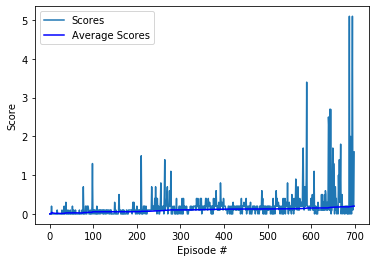

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), scores_mean, c='b', label='Average Scores')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

# Watch Agent

In [ ]:
scores_deque = deque(maxlen=100)
agent_scores = []
scores_window = []
scores_moving_avg = []
valid = True
    
    
for i_episode in range(1, 15):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    states = np.reshape(env_info.vector_observations, (1,num_agents*state_size)) # flatten states  
        
    for agent in agents:
        agent.reset()
            
    scores = np.zeros(num_agents) 
        
    for t in range(max_t):
        actions = np.reshape([agent.act(states, add_noise=False) for agent in agents], (1, num_agents*action_size))
        env_info = env.step(actions)[brain_name]
            
        next_states = np.reshape(env_info.vector_observations, (1, num_agents*state_size)) 
        rewards = env_info.rewards                   
        dones = env_info.local_done 
 
 
                    
        states = next_states
        scores += np.max(rewards)
        if np.any(dones):
            break 
        
        
score = np.max(scores)
scores_deque.append(score)
scores_window.append(score)
scores_moving_avg.append(np.mean(scores_window))
